In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk
import theano
import exoplanet as xo
import pymc3 as pm
import theano.tensor as tt
from scipy.signal import savgol_filter
import corner

In [2]:
import xoflares
from flarefinder import *

In [3]:
print(xo.__version__)
print(theano.__version__)
print(pm.__version__)
print(xoflares.__version__)

0.1.6
1.0.4
3.6
0.1.0


In [4]:
l = Lightcurve()
l.add_data('YZ CMi')
#l.add_data(curve='https://mast.stsci.edu/api/v0.1/Download/file/?uri=mast:TESS/product/tess2018206045859-s0001-0000000441420236-0120-s_tp.fits')

In [5]:
o = OddsRatioDetector(l)
lnO, ts = o.oddsratio()
flarelist, Nflares, maxlist = o.thresholder(lnO, thresh = 10, expand=0, returnmax=True)

In [6]:
print(len(flarelist))

61


In [7]:
print(maxlist)

[(41.1350737525879, 85), (410.63363083297617, 428), (125.49376761673396, 569), (234.47557881699308, 1026), (14.46569247474727, 1536), (186.0124871733338, 1634), (161.16482126804945, 1698), (124.0529182897191, 1901), (50.462624000930106, 2252), (29.228244876478197, 2770), (706.580138742441, 3261), (12.24743939316315, 3541), (10.989188805947174, 3935), (29.763973633655176, 4003), (448.83085919347013, 4297), (78.70046378977034, 4346), (16.16251969573338, 4706), (33.959431579972055, 4775), (18.358799847521155, 5731), (24.170453395363317, 6902), (19.159917294307387, 7602), (19.290707513570982, 7671), (42.20970586315234, 7799), (2027.7340194700846, 8247), (48.18720789867968, 8347), (16.194100171072826, 8362), (441.6843251949499, 8661), (145.07367586254287, 9010), (32.81981325742339, 9136), (18.405541935718873, 9360), (94.39211819554136, 9633), (10.029957410263572, 9742), (3832.781233441305, 9854), (370.5559354147206, 9967), (22.565795656170756, 10560), (47.498235349096994, 10893), (8328.0223

In [8]:
l.time /=(24*3600)


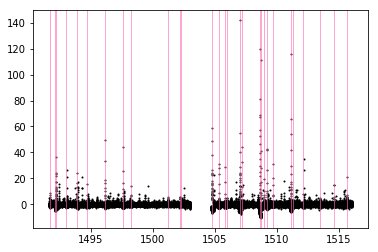

In [9]:
for i in flarelist:
    plt.axvspan(l.time[i[0]], l.time[i[1]], facecolor='hotpink', alpha = .6)

# plt.xlim(l.time.min,l.time.max)   
#plt.ylim(-.0001,.0001)
#plt.xlim(1504,1509)
#plt.xlim(1492.1,1492.3)   
plt.scatter(l.time, l.flux,s=1,c='k')

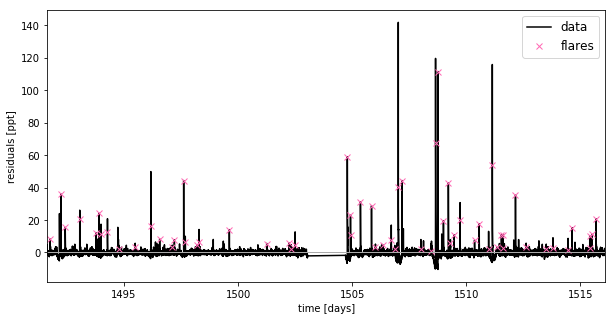

In [10]:
peaks = []
# amp = []

for i in range(len(maxlist)):
    peaks.append(maxlist[i][1])

# for i in range(len(maxlist)):
#     amp.append((maxlist[i][0]))
amp = l.flux[peaks]

plt.figure(figsize=(10, 5))
plt.plot(l.time, l.flux, "k", label="data")
plt.plot(l.time[peaks], l.flux[peaks], "x", color = "hotpink", label="flares")
plt.axhline(0, color="#aaaaaa", lw=1)
plt.ylabel("residuals [ppt]")
plt.xlabel("time [days]")
plt.legend(fontsize=12, loc=1)
#plt.xlim(1330,1335)
plt.xlim(l.time.min(), l.time.max());    

In [11]:
print(amp)

[  8.40856171  36.11725998  15.41719532  20.84280968  12.27565861
  24.22869873  11.14512825  12.43859959   1.98808944   3.65507889
  16.1578331    8.36707497   3.37740517   7.81666279  44.36059952
   6.53057003   4.63284492   6.67639732  14.10707092   5.24461365
   5.95219088   2.27921581   4.39461136  58.99964523  22.97553825
  11.03421974  31.13845062  28.82971573   3.17774034   4.91099644
   7.93716812   2.45500183  40.48597336  44.36212921   2.3694067
   1.22052097  67.22663879 111.5355835   19.61991692  42.82080078
   6.08524704  10.91547966  19.98191452   7.59628534  17.66646004
   2.03537655  53.9228096    3.27754545  10.98708725  11.03119659
   2.50996876  35.29117203   3.61293316   2.3718605    2.9661684
   1.75482798  15.28744698  10.32487106   2.52611637  11.14233971
  20.76050758]


In [12]:
#l.flux = (l.flux - 1.0)  * 1e3
# l.time = l.time/24*3600
### don't know what this is
# texp = lcf.hdu[1].header['FRAMETIM'] * lcf.hdu[1].header["NUM_FRM"]
# texp /= 60.0 * 60.0 * 24.0
texp = 0.001388888888888889
ref_time = 0.5 * (l.time.min() + l.time.max())
print(ref_time)

#lc.plot(normalize=False, ylabel='Relative flux [ppt]')

1503.8641948479585


In [13]:
# find some flares
# mflare = l.flux < 3.5 * np.sqrt(np.mean(l.flux**2))
# print(mflare)

cads = l.cadenceno - l.cadenceno[0]
x = l.time - ref_time
y = l.flux #  we're working with the data with a savgol subtracted


#number of points within each flare, get this from flarelist!
npts = []

for i in range(len(flarelist)):

    k = flarelist[i][1] - flarelist[i][0]
    npts.append(k)

        
tpeaks = x[peaks]
print(tpeaks)
ampls = amp
fwhms = np.asarray(npts) * (2/1440)
npeaks = Nflares


[-12.10898113 -11.63258221 -11.43674491 -10.80201058 -10.093665
  -9.95755169  -9.86866139  -9.5867126   -9.09920556  -8.36864056
  -7.68668847  -7.29779573  -6.7491798   -6.6547346   -6.24639824
  -6.17834222  -5.66861687  -5.57278302  -4.24500043  -2.60888971
  -1.6366714   -1.54083862  -1.36306196   0.92581449   1.06470332
   1.08553664   1.50081397   1.98553509   2.16053454   2.47164447
   2.85080935   3.00219742   3.15775207   3.31469554   4.14802266
   4.61051847   4.79107225   4.89940448   5.13829083   5.35356621
   5.43967633   5.60634102   5.86606004   6.50077375   6.70632635
   7.11604236   7.27853979   7.4799254    7.67853318   7.73825438
   7.74242098   8.29518889   8.75768006   9.64655043   9.93682171
  10.59791714  10.77846819  11.54928112  11.55622537  11.64927833
  11.82705105]


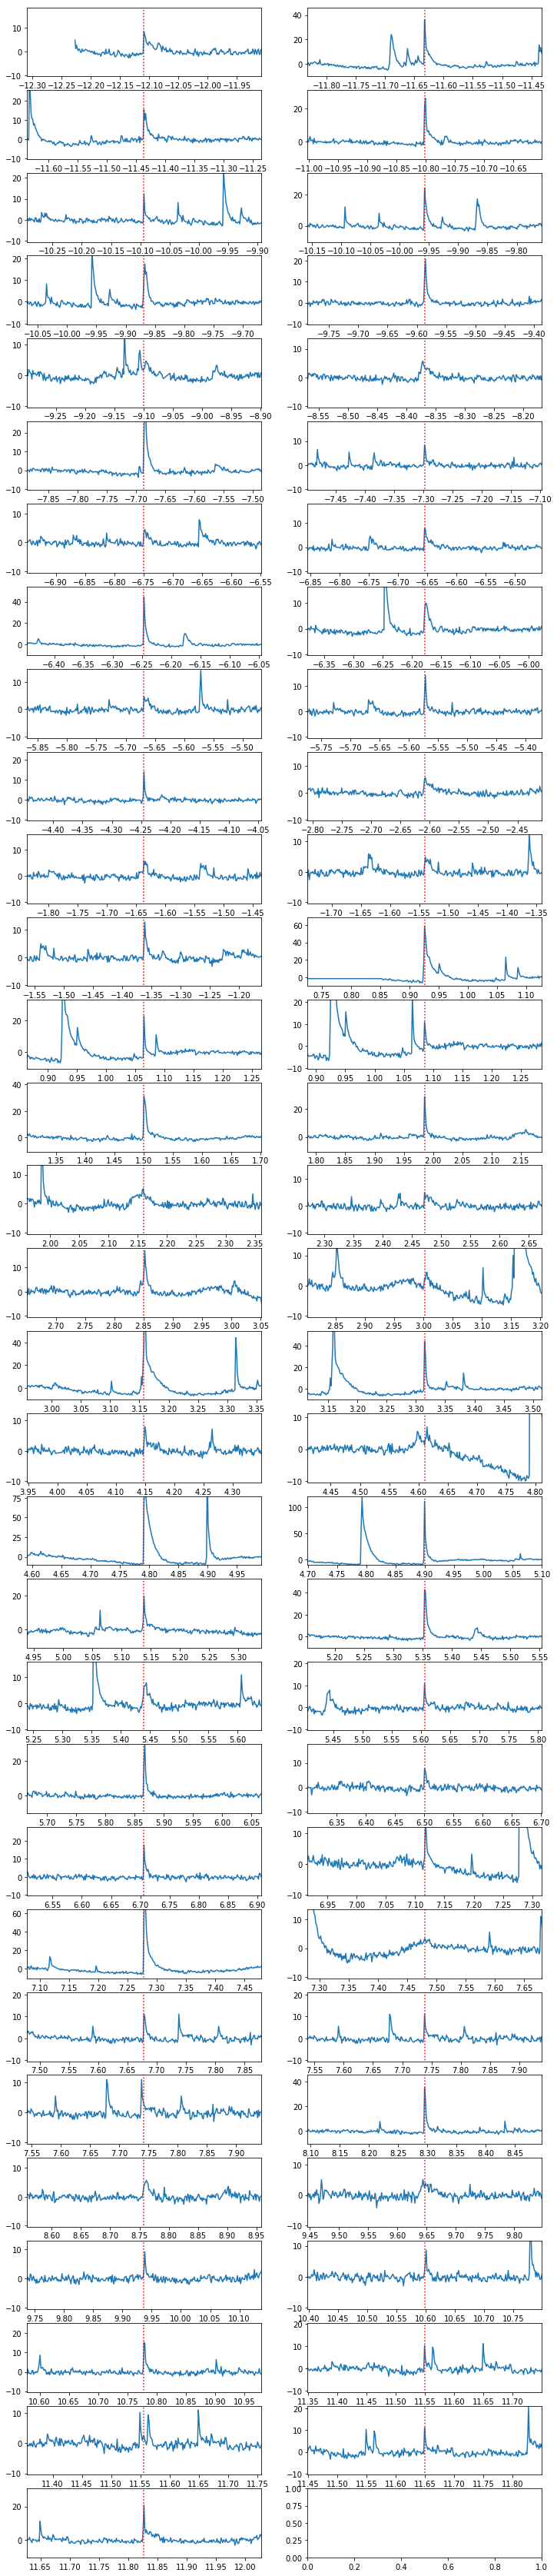

In [14]:
fig, axes = plt.subplots(ncols=2, nrows=np.ceil(npeaks/2).astype(int), figsize=[12,npeaks])
axes = axes.flatten()
for i in range(npeaks):
    ax = axes[i]
    ax.plot(x, y)
    ax.axvline(tpeaks[i], np.min(y), np.max(y), color='r', linestyle=':')
    ax.set_xlim(tpeaks[i]-0.2, tpeaks[i]+0.2)
    ax.set_ylim(np.min(y), np.max(ampls[i]+10))

Text(0, 0.5, 'power')

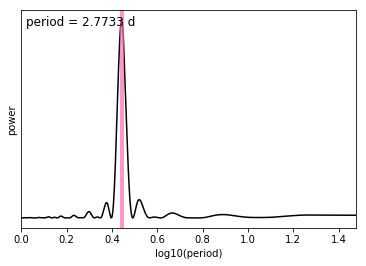

In [15]:
# determine the rotation period of the star
y = (l.raw_flux-1)*1e3
yerr = l.flux_error * 1e3

results = xo.estimators.lomb_scargle_estimator(
    x, y, max_peaks=1, min_period=1.0, max_period=30.0,
    samples_per_peak=50)

peak = results["peaks"][0]
ls_period = peak["period"]
freq, power = results["periodogram"]
plt.plot(-np.log10(freq), power, "k")
plt.axvline(np.log10(ls_period), color="hotpink", lw=4, alpha=0.7)
plt.xlim((-np.log10(freq)).min(), (-np.log10(freq)).max())
plt.annotate("period = {0:.4f} d".format(ls_period),
             (0, 1), xycoords="axes fraction",
             xytext=(5, -5), textcoords="offset points",
             va="top", ha="left", fontsize=12)
plt.yticks([])
plt.xlabel("log10(period)")
plt.ylabel("power")

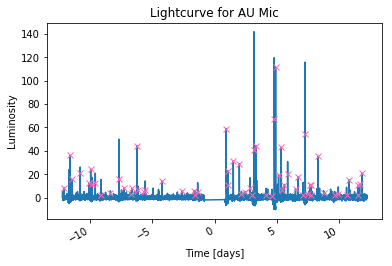

In [16]:
fig, ax = plt.subplots(1)
plt.title('Lightcurve for AU Mic')

ampls_1000 = np.array(ampls)/1000
plt.plot(x, l.flux)
plt.plot(tpeaks, ampls, "x", color = "hotpink", label="outliers")
fig.autofmt_xdate()
plt.xlabel('Time [days]')
plt.ylabel('Luminosity')
plt.show()

In [17]:
# GP model for smoothing using above period
def build_model(mask=None, start=None):
    if mask is None:
        mask = np.ones_like(x, dtype=bool)
    with pm.Model() as model:

        # The mean flux of the time series
        mean = pm.Normal("mean", mu=0, sd=15.0)

        # A jitter term describing excess white noise
        logs2 = pm.Normal("logs2", mu=2*np.log(np.min(yerr[mask])), sd=5.0)

        # A SHO term to capture long term trends
        logS = pm.Normal("logS", mu=0.0, sd=15.0, testval=np.log(np.var(y[mask])))
        logw = pm.Normal("logw", mu=np.log(2*np.pi/10.0), sd=10.0)
        term1 = xo.gp.terms.SHOTerm(log_S0=logS, log_w0=logw, Q=1/np.sqrt(2))
        
        # The parameters of the RotationTerm kernel
        logamp = pm.Normal("logamp", mu=np.log(np.var(y[mask])), sd=5.0)
        logperiod = pm.Normal("logperiod", mu=np.log(ls_period), sd=0.2)
        period = pm.Deterministic("period", tt.exp(logperiod))
        logQ0 = pm.Normal("logQ0", mu=1.0, sd=10.0)
        logdeltaQ = pm.Normal("logdeltaQ", mu=2.0, sd=10.0)
        mix = pm.Uniform("mix", lower=0, upper=1.0)
        term2 = xo.gp.terms.RotationTerm(
            log_amp=logamp,
            period=period,
            log_Q0=logQ0,
            log_deltaQ=logdeltaQ,
            mix=mix
        )

        tpeak = pm.Normal("tpeak", mu=tpeaks, sd=np.ones_like(tpeaks) * 0.003,
                      testval=tpeaks, shape=npeaks)
        logFwhm = pm.Normal("logFwhm", mu=np.log(fwhms), sd=1.0, testval=np.log(fwhms),
                        shape=npeaks)
        logAmpl = pm.Normal("logAmpl", mu=np.log(ampls), sd=1.0, testval=np.log(ampls),
                        shape=npeaks)
        fwhm = pm.Deterministic("fwhm", tt.exp(logFwhm))
        ampl = pm.Deterministic("ampl", tt.exp(logAmpl))
        
        light_curve = xoflares.get_light_curve(x[mask], tpeak, fwhm, ampl, texp=texp, oversample=9)
        pm.Deterministic("light_curve", light_curve)
        model.light_curves = light_curve

        # Set up the Gaussian Process model
        kernel = term1 + term2
        gp = xo.gp.GP(kernel, x[mask], yerr[mask]**2 + tt.exp(logs2), J=6)

        # Compute the Gaussian Process likelihood and add it into the
        # the PyMC3 model as a "potential"
        pm.Potential("loglike", gp.log_likelihood(y[mask] - mean - light_curve))

        # Compute the mean model prediction for plotting purposes
        pm.Deterministic("pred", gp.predict())

        # Optimize to find the maximum a posteriori parameters
        if start is None:
            start = model.test_point
        map_soln = xo.optimize(start=start, vars=[mean, logs2])
        map_soln = xo.optimize(start=map_soln, vars=[mean, logs2, logS, logw])
        map_soln = xo.optimize(start=map_soln, vars=[fwhm, mean])
        map_soln = xo.optimize(start=map_soln, vars=[ampl, mean])
        map_soln = xo.optimize(start=map_soln, vars=[fwhm, ampl])
        map_soln = xo.optimize(start=map_soln, vars=[tpeak])
        map_soln = xo.optimize(start=map_soln, vars=[mean, logs2, logamp, logQ0, logdeltaQ, mix])
        map_soln = xo.optimize(start=map_soln, vars=[mean, logs2])
        map_soln = xo.optimize(start=map_soln, vars=[mean, logs2, logS, logw])
        map_soln = xo.optimize(start=map_soln, vars=[fwhm, mean])
        map_soln = xo.optimize(start=map_soln, vars=[ampl, mean])
        map_soln = xo.optimize(start=map_soln, vars=[fwhm, ampl])
        map_soln = xo.optimize(start=map_soln, vars=[tpeak])
        map_soln = xo.optimize(start=map_soln, vars=[tpeak,fwhm, ampl])
    return model, map_soln

model0, map_soln0 = build_model()

/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[t

optimizing logp for variables: ['logs2', 'mean']


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]

message: Optimization terminated successfully.
logp: -180385.61382502038 -> -45367.426381043944
optimizing logp for variables: ['logw', 'logS', 'logs2', 'mean']


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


message: Optimization terminated successfully.
logp: -45367.426381043944 -> -38129.450564236475


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]

optimizing logp for variables: ['mean', 'logFwhm']


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]

message: Desired error not necessarily achieved due to precision loss.
logp: -38129.450564236475 -> -35052.968745428436
optimizing logp for variables: ['mean', 'logAmpl']


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]

message: Desired error not necessarily achieved due to precision loss.
logp: -35052.968745428436 -> -34629.396059507955
optimizing logp for variables: ['logAmpl', 'logFwhm']


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]

message: Desired error not necessarily achieved due to precision loss.
logp: -34629.396059507955 -> -34241.50766313003


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


optimizing logp for variables: ['tpeak']


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]

message: Desired error not necessarily achieved due to precision loss.
logp: -34241.50766313003 -> -32826.569732879296
optimizing logp for variables: ['mix_interval__', 'logdeltaQ', 'logQ0', 'logamp', 'logs2', 'mean']


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]

message: Desired error not necessarily achieved due to precision loss.
logp: -32826.569732879296 -> -31038.531927755364
optimizing logp for variables: ['logs2', 'mean']
message: Optimization terminated successfully.
logp: -31038.531927755364 -> -31038.531927755364
optimizing logp for variables: ['logw', 'logS', 'logs2', 'mean']
message: Optimization terminated successfully.
logp: -31038.531927755364 -> -29183.51922751334
optimizing logp for variables: ['mean', 'logFwhm']


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]

message: Desired error not necessarily achieved due to precision loss.
logp: -29183.51922751334 -> -28748.70754338505
optimizing logp for variables: ['mean', 'logAmpl']


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]

message: Desired error not necessarily achieved due to precision loss.
logp: -28748.70754338505 -> -26110.93782415561
optimizing logp for variables: ['logAmpl', 'logFwhm']


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]

message: Desired error not necessarily achieved due to precision loss.
logp: -26110.93782415561 -> -25828.10672419129
optimizing logp for variables: ['tpeak']


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]

message: Desired error not necessarily achieved due to precision loss.
logp: -25828.10672419129 -> -25536.17114954119
optimizing logp for variables: ['logAmpl', 'logFwhm', 'tpeak']


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]

message: Desired error not necessarily achieved due to precision loss.
logp: -25536.17114954119 -> -25427.45711193694


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


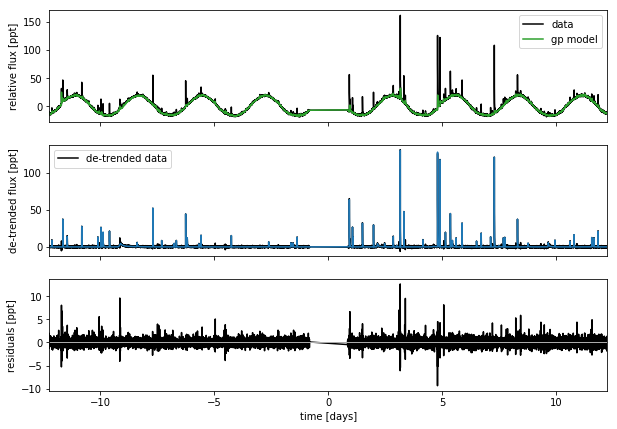

In [18]:
# plot the results of the model fitting + smoothing

def plot_light_curve(model, soln, mask=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)

    fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True)

    ax = axes[0]
    ax.plot(x[mask], y[mask], "k", label="data")
    gp_mod = xo.utils.eval_in_model(model.pred, soln, model=model)
    gp_mod += soln["mean"]
    ax.plot(x[mask], gp_mod, color="C2", label="gp model")
    ax.legend(fontsize=10)
    ax.set_ylabel("relative flux [ppt]")

    ax = axes[1]
    ax.plot(x[mask], y[mask] - gp_mod, "k", label="de-trended data")
    light_curve = xo.utils.eval_in_model(model.light_curves, soln, model=model)

    mod = light_curve
    ax.plot(x[mask], mod,)
    ax.legend(fontsize=10)
    ax.set_ylabel("de-trended flux [ppt]")

    ax = axes[2]
    mod = gp_mod + light_curve
    ax.plot(x[mask], y[mask] - mod, "k")
    ax.axhline(0, color="#aaaaaa", lw=1)
    ax.set_ylabel("residuals [ppt]")
    ax.set_xlim(x[mask].min(), x[mask].max())
    ax.set_xlabel("time [days]")
    
    return fig
    
plot_light_curve(model0, map_soln0);

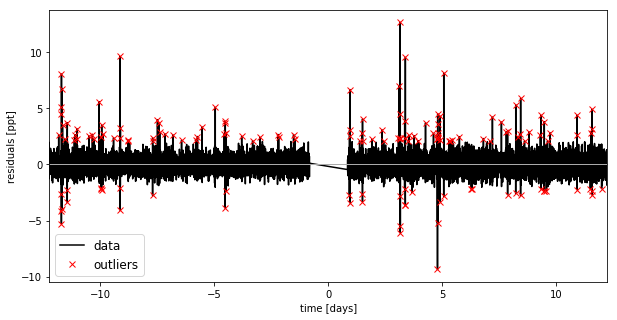

In [19]:
# subtract off the model to get residual (flatten light curve w/ spots/rotation removed)

mod = map_soln0["pred"] + map_soln0["mean"] + map_soln0["light_curve"]
resid = y - mod
rms = np.sqrt(np.median(resid**2))
mask = np.abs(resid) < 5 * rms

plt.figure(figsize=(10, 5))
plt.plot(x, resid, "k", label="data")
plt.plot(x[~mask], resid[~mask], "xr", label="outliers")
plt.axhline(0, color="#aaaaaa", lw=1)
plt.ylabel("residuals [ppt]")
plt.xlabel("time [days]")
plt.legend(fontsize=12, loc=3)
plt.xlim(x.min(), x.max());

optimizing logp for variables: ['logs2', 'mean']


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]

message: Desired error not necessarily achieved due to precision loss.
logp: -25427.45711193694 -> -24450.661331865667
optimizing logp for variables: ['logw', 'logS', 'logs2', 'mean']


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]

message: Desired error not necessarily achieved due to precision loss.
logp: -24450.661331865667 -> -24098.145425115174
optimizing logp for variables: ['mean', 'logFwhm']


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]

message: Desired error not necessarily achieved due to precision loss.
logp: -24098.145425115174 -> -24091.178850596054
optimizing logp for variables: ['mean', 'logAmpl']
message: Optimization terminated successfully.
logp: -24091.178850596054 -> -24086.654460615024
optimizing logp for variables: ['logAmpl', 'logFwhm']


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]

message: Desired error not necessarily achieved due to precision loss.
logp: -24086.654460615024 -> -24085.513256519338
optimizing logp for variables: ['tpeak']


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]

message: Desired error not necessarily achieved due to precision loss.
logp: -24085.513256519338 -> -24081.6087128914
optimizing logp for variables: ['mix_interval__', 'logdeltaQ', 'logQ0', 'logamp', 'logs2', 'mean']
message: Optimization terminated successfully.
logp: -24081.6087128914 -> -23987.327037254858
optimizing logp for variables: ['logs2', 'mean']
message: Optimization terminated successfully.
logp: -23987.327037254858 -> -23987.327037254858
optimizing logp for variables: ['logw', 'logS', 'logs2', 'mean']


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]

message: Desired error not necessarily achieved due to precision loss.
logp: -23987.327037254858 -> -23929.4798453065
optimizing logp for variables: ['mean', 'logFwhm']


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]

message: Desired error not necessarily achieved due to precision loss.
logp: -23929.4798453065 -> -23924.700312801047
optimizing logp for variables: ['mean', 'logAmpl']
message: Optimization terminated successfully.
logp: -23924.700312801047 -> -23922.280303741663
optimizing logp for variables: ['logAmpl', 'logFwhm']


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]

message: Desired error not necessarily achieved due to precision loss.
logp: -23922.280303741663 -> -23921.83980260231
optimizing logp for variables: ['tpeak']


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]

message: Desired error not necessarily achieved due to precision loss.
logp: -23921.83980260231 -> -23921.33659462017
optimizing logp for variables: ['logAmpl', 'logFwhm', 'tpeak']


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]

message: Desired error not necessarily achieved due to precision loss.
logp: -23921.33659462017 -> -23921.05062007066


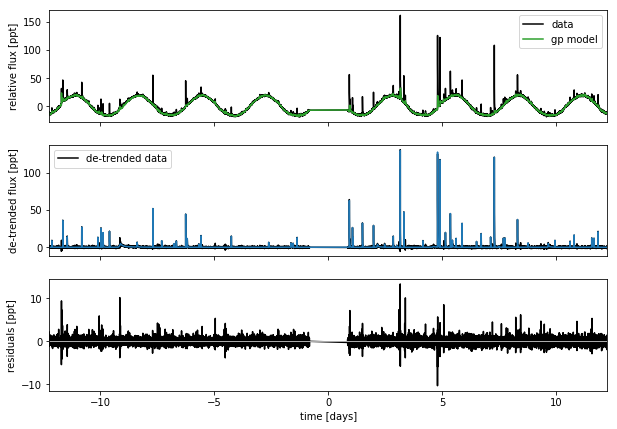

In [20]:

model, map_soln1 = build_model(mask=None, start=map_soln0)
fig = plot_light_curve(model, map_soln1, mask=None)

In [21]:
with model:
    map_soln2 = xo.optimize(start=map_soln1,)


optimizing logp for variables: ['logAmpl', 'logFwhm', 'tpeak', 'mix_interval__', 'logdeltaQ', 'logQ0', 'logperiod', 'logamp', 'logw', 'logS', 'logs2', 'mean']


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]

message: Desired error not necessarily achieved due to precision loss.
logp: -23921.05062007066 -> -23921.047597027715


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


In [22]:
with model:
    mean_field = pm.fit(method='advi', start=map_soln2,  n=100000)

  0%|          | 0/100000 [00:00<?, ?it/s]/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
Average Loss = 25,513: 100%|██████████| 100000/100000 [6:41:02<00:00,  4.42it/s]   
Finished [100%]: Average Loss = 25,513


In [23]:
with model:
    trace = mean_field.sample(3000)

/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


Prot = 2.776969539213323 +0.008168675705262807 - 0.008064345972477849


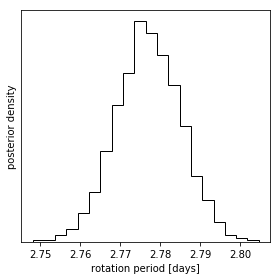

In [24]:
fig, axes = plt.subplots(1,1, figsize=[4, 4])
ax = axes
ax.hist( trace['period'], bins=20, histtype='step', color="k")
plt.yticks([])

ax.set_xlabel("rotation period [days]")
ax.set_ylabel("posterior density");

plt.tight_layout()
fig.savefig('aumic-rotation.png', dpi=200)
q = np.percentile(trace['period'], [16,50,84])
print('Prot = {} +{} - {}'.format(q[1], q[2] - q[1], q[1]-q[0]))


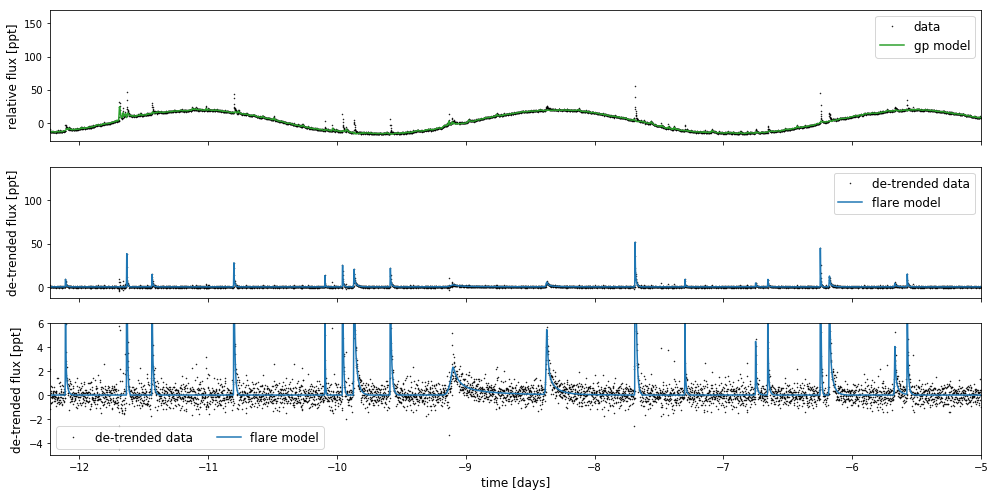

In [25]:
fig, axes = plt.subplots(3, 1, figsize=(14, 7), sharex=True)

ax = axes[0]
ax.plot(x, y, ".k", label="data", ms=1)
gp_mod = np.median(trace['pred'], axis=0)
gp_mod += np.median(trace["mean"])
ax.plot(x, gp_mod, color="C2", label="gp model")
ax.legend(fontsize=12)
ax.set_ylabel("relative flux [ppt]", fontsize=12)

ax = axes[1]
ax.plot(x, y - gp_mod, ".k", label="de-trended data", ms=1)
light_curve = np.median(trace['light_curve'], axis=0)

mod = light_curve
ax.plot(x, mod, label='flare model')
ax.legend(fontsize=12)
ax.set_ylabel("de-trended flux [ppt]", fontsize=12)

ax = axes[2]
# mod = gp_mod + light_curve
# ax.plot(x, y - mod, "k")
# ax.axhline(0, color="#aaaaaa", lw=1)
# ax.set_ylabel("residuals [ppt]", fontsize=12)
ax.plot(x, y - gp_mod, ".k", label="de-trended data", ms=1)
ax.plot(x, mod, label='flare model')

ax.legend(fontsize=12, loc=3, ncol=2)
ax.set_ylabel("de-trended flux [ppt]", fontsize=12)
ax.set_ylim(-5,6)

ax.set_xlim(x.min(), -5)
#ax.set_xlim(0,10)
ax.set_xlabel("time [days]", fontsize=12)

plt.tight_layout()

In [26]:
print(x)
print(y)

[-12.22703925 -12.22565033 -12.22426141 ...  12.22426156  12.22565041
  12.22703925]
[ -9.79685783 -13.36246729 -11.81870699 ... -12.64441013 -11.78431511
 -11.99293137]


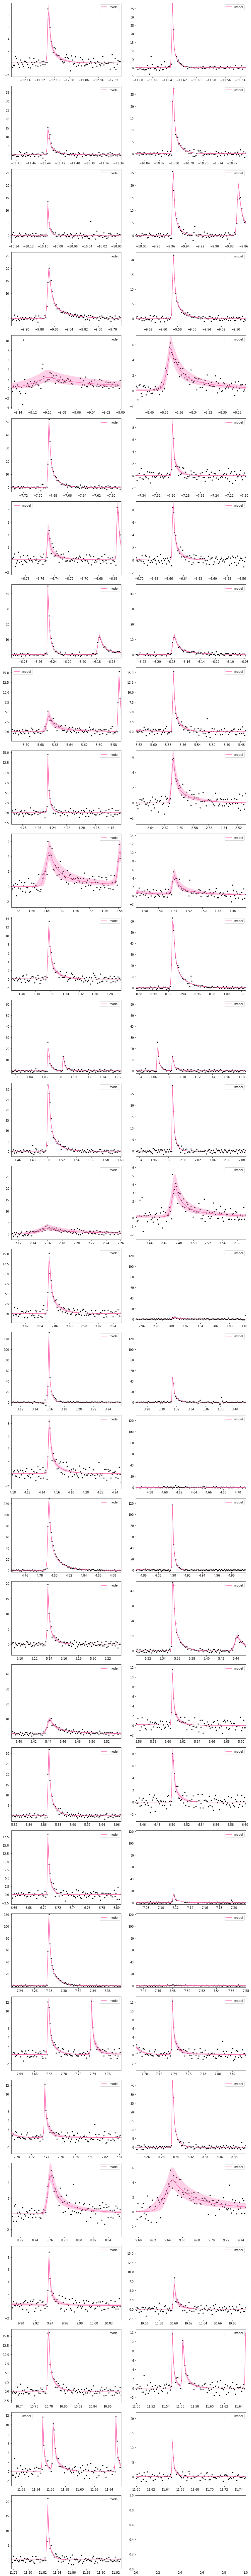

In [27]:
flc =  np.percentile(trace['light_curve'], [16, 50, 84], axis=0)
fig, axes = plt.subplots(ncols=2, nrows=np.ceil(npeaks/2).astype(int), figsize=[12,npeaks*2])
axes = axes.flatten()
for i in range(npeaks):
    timemask = (x >= tpeaks[i]-0.2) * (x < tpeaks[i]+0.2)
    ax = axes[i]
    ax.plot(x[timemask], y[timemask]-gp_mod[timemask], '.k')
    ax.plot(x[timemask], flc[1][timemask], color="hotpink", label="model")
    art = ax.fill_between(x[timemask], flc[0][timemask],
                          flc[2][timemask], color="hotpink", alpha=0.3,
                               zorder=1000)
    art.set_edgecolor("none")
    ax.set_xlim(tpeaks[i]-0.05, tpeaks[i]+0.1)
    ax.set_ylim(np.min(y[timemask]-gp_mod[timemask]) - 1, 1 + np.max(y[timemask]-gp_mod[timemask]))
    ax.legend()
    
fig.tight_layout()

In [30]:
import pickle
filename = 'flare_results_yz_cmi'
outfile = open(filename,'wb')
pickle.dump(trace,outfile)
outfile.close()

In [ ]:
def get_flare_integral(time, tpeak, fwhm, ampl, texp=None, oversample=7):
    """
    calculates the integral of flares. Useful for calculating
    equivalent width and energy
    this is designed to be a post processing step, not run within the
    HMC model. This is mostly because it is slightly awkward to implement
    and integral in theano
    """
    feval = xoflares.get_light_curvenp(time,
                              tpeak,
                              fwhm,
                              ampl,
                              texp,
                              oversample)
    tstart, tend = time[feval > 0][0], feval[feval > 0][-1]
    integral = integrate.quad(xoflares.get_light_curvenp, tstart, tend,
                              points=tpeak,
                              args=(tpeak, fwhm, ampl, texp, oversample))
    return integral

In [ ]:
#get_flare_integral(x, trace['tpeak'], trace['fwhm'], trace['ampl'], texp=0.001388888888888889, oversample=7)